# Lab 1 - Pythagorean Expectation: The Relationship between Runs and Wins


+ Bill James' formula known as _Pythagorean Expectation_ is summarized as
$$
    \text{Pythagorean Win Pct}
        = \frac{\text{Runs Scored}^2}{\text{Runs Scored}^2 + \text{Runs Allowed}^2}
        = \frac{1}{1 + (\text{Runs Allowed}\ /\ \text{Runs Scored})^2}
$$
+ The name comes from the similar appearance to the classic Pythagorean Theorem
+ Pythagorean Expectation is an empirically motivated relationship between the runs scored and allowed by a team and the team's winning percentage.
+ If a team scores more runs, holding runs allowed fixed, its expected winning percentage will go up.
+ This formula is not exact, hence the usage of the term _expected_.
+ This notebook explores the empirical relationship between runs and wins, derives the Pythagorean Expectation formula, and 


## Setup

In [1]:
import pandas as pd

# Load Teams.csv from the Lahman databank
df = pd.read_csv("Teams.csv", usecols=[0, 1, 2, 3, 6, 8, 9, 14, 26, 40])

# Define some extra values: win pct, loss pct, and run differential
df['Wpct'] = df['W'] / df["G"]
df['Lpct'] = 1 - df['Wpct']
df["RD"] = df["R"] - df["RA"]

# Restrict to after the year 2000
df = df.loc[df['yearID'] >= 2000].copy()

df.head()

,yearID,lgID,teamID,franchID,G,W,L,R,RA,name,Wpct,Lpct,RD
2325,2000,AL,ANA,ANA,162,82,80,864,869,Anaheim Angels,0.506173,0.493827,-5
2326,2000,NL,ARI,ARI,162,85,77,792,754,Arizona Diamondbacks,0.524691,0.475309,38
2327,2000,NL,ATL,ATL,162,95,67,810,714,Atlanta Braves,0.586420,0.413580,96
2328,2000,AL,BAL,BAL,162,74,88,794,913,Baltimore Orioles,0.456790,0.543210,-119
2329,2000,AL,BOS,BOS,162,85,77,792,745,Boston Red Sox,0.524691,0.475309,47


## First Look
Let's create scatter plots showing the relationship between runs scored, runs allowed, and run differential.  Clearly as runs scored increases, runs allowed decreased, or run differential increases, we should expect to win more games.   While it is not guaranteed that scoring more runs or allowing fewer runs will yield more wins, the tendency is quite strong.  The strongest relationship is clearly with run differential since winning isn't solely about scoring or preventing runs but doing both.

Also, the relationship appears to be very linear.  The incremental improvement in run differential will yield the same improvement in expected winning percentage regardless the overall size of the run differential.  A team with a net negative 200 run differential improving by 30 runs will see the same increase in expected winning percentage as a team with a net positive 200 run differential improving by 30 runs.


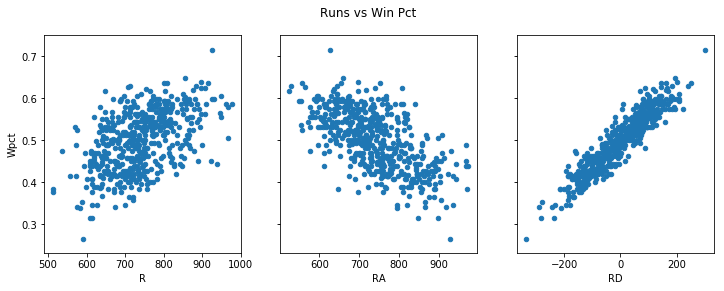

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axarr = plt.subplots(ncols=3, figsize=(12,4), sharey=True)
df.plot.scatter(ax=axarr[0], x='R', y='Wpct')
df.plot.scatter(ax=axarr[1], x='RA', y='Wpct')
df.plot.scatter(ax=axarr[2], x="RD", y='Wpct')
fig.suptitle("Runs vs Win Pct");

## Linear Fit

Let's compute a linear fit for wins against run differential.  This is given by the equation
$$
    \text{Linear Win pct} = \alpha  + \beta \cdot \text{Run Differential per Game}
$$
where $\alpha$ gives $\text{Average Wins}$ (which should be 81) and $\beta$ gives $\text{Wins per Unit Run Differential}$.

The next cell computes $\alpha=0.500$ and $\beta = 0.101$.  This shows that the average winning percentage is naturally .500 and that an improvement of total run differential by 10 runs will increase the number of expected wins by 1 (or increase expected winning percentage by $0.006 = .101 \cdot 10\ /\ 162$).

Computed Linear Fit:
xWpct = 0.500 + 0.101 * RDperG


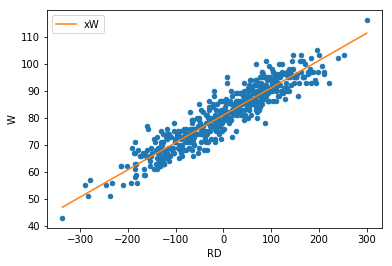

In [22]:
import numpy as np
import statsmodels.formula.api as smf

# Compute a linear fit
formula = 'W ~ RD'
results = smf.ols(formula, data=df).fit()
# print(results.summary2())  # print a summary of the results (not necessary but shows how diagnotic information)

print("Computed Linear Fit:")
print("====================")
s = "xWpct = {Intercept:.3f} + {RD:.3f} * RDperG".format(
    Intercept=results.params['Intercept'] / 162, RD=results.params['RD'])
print(s)

fig, ax = plt.subplots()
df.plot.scatter(ax=ax, x="RD", y='W')

rd = np.linspace(df['RD'].min(), df['RD'].max())
xW = results.params['Intercept'] + rd * results.params['RD']
df['xWpct'] = results.fittedvalues / 162
plt.plot(rd, xW, color='C1', label='xW')
plt.legend();

## Pythagorean Expectation

Recall from above Bill James' formula for Pythagorean Expectation:
$$
    \text{Pythagorean Win Pct}
        = \frac{\text{Runs Scored}^2}{\text{Runs Scored}^2 + \text{Runs Allowed}^2}
        = \frac{1}{1 + (\text{Runs Allowed}\ /\ \text{Runs Scored})^2}
$$

What's the difference between Pythagorean Expectation and our linear fit above?
$$
    \text{Linear Win Pct} = 0.500 + 0.101 \cdot \text{Run Differential per Game}
$$

Performance wise, both formulas do the trick.  Normally we'd opt for a simpler formula like the linear win percentage formula but the Pythagorean formula is still fairly simple and elegant.  There are a few other areas where the Pythagorean formula is a bit better.

If the run differential is every really high or low, the linear win percentage formula could be greater than 1 or negative.  The Pythagorean formula also does a bit better in handling teams at the extremes (like the 2001 Seattle Mariners or 2003 Detroit Tigers).  

Finally, the Pythagorean formula better quantifies performance by being dependent on the performance ratio
$$
    \text{Runs Allowed}\ /\ \text{Runs Scored}
$$
instead of the run differential
$$
    \text{Runs Scored} - \text{Runs Allowed}.
$$
To see why this is more desirable, consider an era where defense and pitching are strong and fewer runs scored. The Pythagorean formula is indifferent to this change in run scoring environment because all that matters is the ratio.  However, the linear win percentage formula would still require a 10 run change in total run differential to increase expected wins by 1.  A run poor environment should require fewer runs to increase winning percentage and a run rich environment should require more.  The Pythagorean formula captures this.

The plot in the following cell shows how win percentage, expected win percentage from the linear fit, and the Pythagorean Expectation compare as a function of the perforamnce ratio.

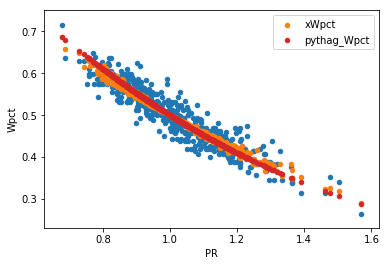

In [31]:
K = 2
df['PR'] = df['RA'] / df['R']
df['pythag_Wpct'] = 1 / (1 + df['PR']**K)

fig, ax = plt.subplots()
df.plot.scatter(ax=ax, x="PR", y='Wpct')
df.plot.scatter(ax=ax, x="PR", y='xWpct', color='C1', label='xWpct')
df.plot.scatter(ax=ax, x="PR", y='pythag_Wpct', color='C3', label='pythag_Wpct')
plt.legend()
ax.set_ylabel('Wpct');

## Deriving the Pythagorean Expectation Formula

Where does the exponent come from in the Pythagorean Expectation formula?  Consider the ratio of wins to losses:
$$
    \frac{\text{Pythagorean Win Pct}}{\text{Pythagorean Loss Pct}}
        = \frac{\text{Pythagorean Win Pct}}{1 - \text{Pythagorean Win Pct}}
        = \left(\frac{\text{Runs Scored}}{\text{Runs Allowed}}\right)^2
$$
If we take the log we get a linear relationship:
$$
    \log\left(\frac{\text{Pythagorean Win Pct}}{\text{Pythagorean Loss Pct}}\right)
        = 2\log\left(\frac{\text{Runs Scored}}{\text{Runs Allowed}}\right)
$$

Therefore, we should explore the log win-loss ratio on the left-hand side and the log run ratio on the right-hand side. 

In the next cell, we show the scatter plot and the result of the linear fit
$$
    \text{Log Win-Loss Ratio} = K \cdot \text{Log Run Ratio}
$$

The linear relationship of the log values is clear.  And our fit produces a value of $K = 1.87$.  While not exactly the same, taking $K=2$ is "good enough" which shows where the Pythagorean Expectation formula comes from.

Computed Linear Fit:
xlog_Wrat = 1.87 * log_Rrat


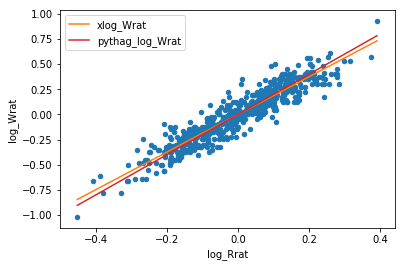

In [32]:
df['log_Rrat'] = np.log(df["R"] / df["RA"])
df['log_Wrat'] = np.log(df["W"] / df["L"])

formula = 'log_Wrat ~ 0 + log_Rrat'
results = smf.ols(formula, data=df).fit()
# print(results.summary2())  # print a summary of the results (not necessary but shows how diagnotic information)

print("Computed Linear Fit:")
print("====================")
s = "xlog_Wrat = {log_Rrat:.2f} * log_Rrat".format(log_Rrat=results.params['log_Rrat'])
print(s)

fig, ax = plt.subplots()
df.plot.scatter(ax=ax, x='log_Rrat', y='log_Wrat')

log_Rrat = np.linspace(df['log_Rrat'].min(), df['log_Rrat'].max())
pythag_log_Wrat = log_Rrat * 2
xlog_Wrat = log_Rrat * results.params['log_Rrat']
df['xlog_Wrat'] = results.fittedvalues
plt.plot(log_Rrat, xlog_Wrat, color='C1', label='xlog_Wrat')
plt.plot(log_Rrat, pythag_log_Wrat, color='C3', label='pythag_log_Wrat')
plt.legend();

## Pythagorean Luck

In [19]:
df['pythag_luck'] = 162 * (df['Wpct'] - df['pythag_Wpct'])

In [20]:
df.sort_values(by='pythag_luck', ascending=False).head(10)

,yearID,lgID,teamID,franchID,G,W,L,R,RA,name,Wpct,Lpct,RD,pythag_Wpct,pythag_luck
2832,2016,AL,TEX,TEX,162,95,67,765,757,Texas Rangers,0.586420,0.413580,8,0.505256,13.148512
2475,2005,NL,ARI,ARI,162,77,85,696,856,Arizona Diamondbacks,0.475309,0.524691,-160,0.397991,12.525397
2463,2004,AL,NYA,NYY,162,101,61,897,808,New York Yankees,0.623457,0.376543,89,0.552058,11.566674
2578,2008,AL,LAA,ANA,162,100,62,765,697,Los Angeles Angels of Anaheim,0.617284,0.382716,68,0.546411,11.481382
2535,2007,NL,ARI,ARI,162,90,72,712,732,Arizona Diamondbacks,0.555556,0.444444,-20,0.486152,11.243337
2687,2012,AL,BAL,BAL,162,93,69,712,705,Baltimore Orioles,0.574074,0.425926,7,0.504940,11.199737
2825,2016,NL,PHI,PHI,162,71,91,610,796,Philadelphia Phillies,0.438272,0.561728,-186,0.369985,11.062403
2618,2009,AL,SEA,SEA,162,85,77,640,692,Seattle Mariners,0.524691,0.475309,-52,0.461020,10.314700
2452,2004,NL,CIN,CIN,162,76,86,750,907,Cincinnati Reds,0.469136,0.530864,-157,0.406093,10.212854
2374,2001,NL,NYN,NYM,162,82,80,642,713,New York Mets,0.506173,0.493827,-71,0.447745,9.465318


In [21]:
df.sort_values(by='pythag_luck', ascending=True).head(10)

,yearID,lgID,teamID,franchID,G,W,L,R,RA,name,Wpct,Lpct,RD,pythag_Wpct,pythag_luck
2764,2014,AL,OAK,OAK,162,88,74,729,572,Oakland Athletics,0.543210,0.456790,157,0.618944,-12.268967
2512,2006,AL,CLE,CLE,162,78,84,870,782,Cleveland Indians,0.481481,0.518519,88,0.553118,-11.605122
2803,2015,AL,TOR,TOR,162,93,69,891,670,Toronto Blue Jays,0.574074,0.425926,221,0.638794,-10.484622
2364,2001,NL,COL,COL,162,73,89,923,906,Colorado Rockies,0.450617,0.549383,17,0.509294,-9.505611
2794,2015,AL,OAK,OAK,162,68,94,694,729,Oakland Athletics,0.419753,0.580247,-35,0.475419,-9.017869
2623,2009,AL,TOR,TOR,162,75,87,798,771,Toronto Blue Jays,0.462963,0.537037,27,0.517203,-8.786938
2503,2005,AL,TOR,TOR,162,80,82,775,705,Toronto Blue Jays,0.493827,0.506173,70,0.547192,-8.645060
2753,2014,NL,COL,COL,162,66,96,755,818,Colorado Rockies,0.407407,0.592593,-63,0.460013,-8.522152
2337,2000,NL,HOU,HOU,162,72,90,938,944,Houston Astros,0.444444,0.555556,-6,0.496812,-8.483533
2389,2002,AL,BOS,BOS,162,93,69,859,665,Boston Red Sox,0.574074,0.425926,194,0.625267,-8.293208


## 10 Runs to a Win?

+ Differentiate
+ Runs to win table